# Drowsiness Detection using Mouth only (Open and Closing of mouth)

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths and parameters
data_dir = r"C:\Users\HP\OneDrive\FINAL DROWSY\yawn data"
batch_size = 36
img_size = (224, 224)



# Data Loading and Augmentation

In [1]:
# Data augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5]
)
val_data_gen = ImageDataGenerator(rescale=1./255)

# Load the data
def load_data(data_dir, img_size):
    x, y = [], []
    for label, folder_name in enumerate(['no yawn', 'yawn']):
        folder_path = os.path.join(data_dir, folder_name)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            x.append(img)
            y.append(label)
    return np.array(x), np.array(y)


In [3]:

x, y = load_data(data_dir, img_size)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

# Define the transfer learning model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


# Model Compilation and Training 

In [16]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('yawn_detection_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=val_data_gen.flow(x_val, y_val, batch_size=batch_size),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the model
model.save('yawn_detection_model.keras')


Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 195s 892ms/step - accuracy: 0.9309 - loss: 0.1736 - val_accuracy: 0.9395 - val_loss: 0.1569
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 179s 876ms/step - accuracy: 0.9358 - loss: 0.1627 - val_accuracy: 0.9217 - val_loss: 0.1958
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 181s 886ms/step - accuracy: 0.9326 - loss: 0.1687 - val_accuracy: 0.9411 - val_loss: 0.1510
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 180s 880ms/step - accuracy: 0.9266 - loss: 0.1705 - val_accuracy: 0.9345 - val_loss: 0.1636
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9312 - loss: 0.1564 - val_accuracy: 0.9295 - val_loss: 0.1843
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9332 - loss: 0.1671 - val_accuracy: 0.9206 - val_loss: 0.1987
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9459 - loss: 0.1435 - val_accuracy: 0.9461 - val_loss: 0.1386
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9354 - loss: 0.152

In [17]:
# Save the model
model.save('yawn_detection_model.keras')

In [27]:
model = load_model('yawn_detection_model.keras')

In [28]:
model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 6,196,293 (23.64 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,625,540 (10.02 MB)

# Prediction and Evaluation Metrices

In [18]:
# Print training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_data_gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False))

print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9506
Validation Accuracy: 0.9467
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.9483 - loss: 0.1512
Test Accuracy: 0.9512


26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 538ms/step


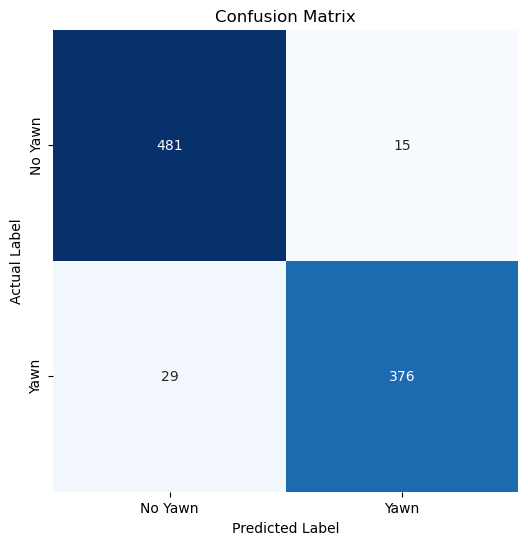

Classification Report:
               precision    recall  f1-score   support

     No Yawn       0.94      0.97      0.96       496
        Yawn       0.96      0.93      0.94       405

    accuracy                           0.95       901
   macro avg       0.95      0.95      0.95       901
weighted avg       0.95      0.95      0.95       901



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict labels for the test set
y_pred = model.predict(val_data_gen.flow(x_test, batch_size=batch_size, shuffle=False))
y_pred_classes = np.where(y_pred > 0.5, 1, 0).flatten()  # Convert probabilities to binary classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['No Yawn', 'Yawn'], yticklabels=['No Yawn', 'Yawn'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred_classes, target_names=['No Yawn', 'Yawn'])
print("Classification Report:\n", class_report)


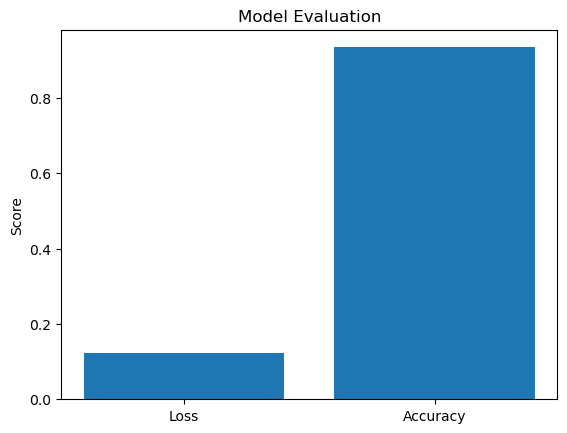

In [20]:
# Plot evaluation
plt.bar(['Loss', 'Accuracy'], [test_loss, test_acc])
plt.title('Model Evaluation')
plt.ylabel('Score')
plt.show()

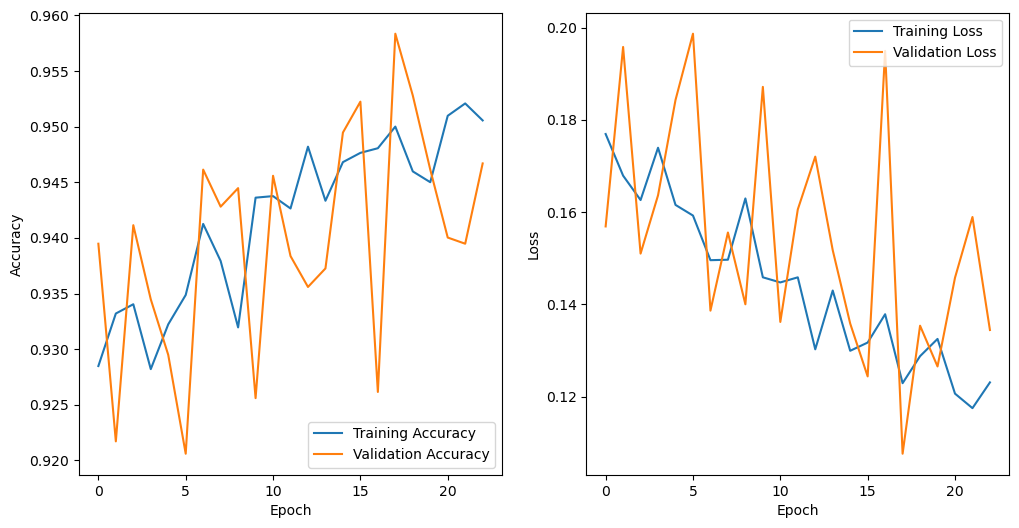

In [21]:

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Real time Evaluation

In [ ]:
import numpy as np
import cv2
import time
from tensorflow.keras.models import load_model
import pyttsx3

# Load the trained model
model = load_model('yawn_detection_model.keras')

# Initialize webcam
cap = cv2.VideoCapture(0)

# Initialize variables for yawn detection
prev_yawn_status = False
yawn_start_time = None
yawn_end_time = None
total_yawns = 0
yawn_threshold = 5  # Number of yawns to detect drowsiness

# Initialize TTS engine
engine = pyttsx3.init()

# Function to play alert sound
def play_alert_sound():
    engine.say("Warning! Drowsiness detected due to multiple yawns.")
    engine.runAndWait()

# Function to update yawn status and count yawns
def update_yawn_status(yawn_status):
    global prev_yawn_status, yawn_start_time, yawn_end_time, total_yawns
    if yawn_status != prev_yawn_status:
        if yawn_status:  # Yawn started
            yawn_start_time = time.time()
        else:  # Yawn ended
            yawn_end_time = time.time()
            yawn_duration = yawn_end_time - yawn_start_time
            if yawn_duration > 1:  # Consider yawn if duration > 1 second
                total_yawns += 1
                if total_yawns >= yawn_threshold:
                    play_alert_sound()  # Play sound alert
        prev_yawn_status = yawn_status

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    roi = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (224, 224))  # Ensure img_size is defined as (224, 224)
    roi = roi.astype(np.float32) / 255.0
    roi = np.expand_dims(roi, axis=0)

    # Predict yawning status
    prediction = model.predict(roi)
    yawn_status = prediction[0][0] > 0.5

    # Update yawn status
    update_yawn_status(yawn_status)

    # Display results
    yawn_label = 'Yawning' if yawn_status else 'Not Yawning'
    cv2.putText(frame, f'Status: {yawn_label}', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f'Yawns Count: {total_yawns}', (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Yawn Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
